<a href="https://colab.research.google.com/github/neoyipeng2018/acct725_teachingmaterials/blob/main/LLM_Lesson_4D_Agents_Workflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Source: https://langchain-ai.github.io/langgraph/tutorials/workflows/#building-blocks-the-augmented-llm
![Augmented LLM](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/augmented_llm.png)


In [49]:
!pip install langgraph -qU
!pip show langgraph #0.4.8

Name: langgraph
Version: 0.4.8
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: 


In [50]:
!pip install langchain_core -qU
!pip show langchain_core #0.3.63

Name: langchain-core
Version: 0.3.65
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: jsonpatch, langsmith, packaging, pydantic, PyYAML, tenacity, typing-extensions
Required-by: langchain, langchain-community, langchain-groq, langchain-text-splitters, langgraph, langgraph-checkpoint, langgraph-prebuilt


In [51]:
!pip install -qU langchain-groq
!pip show langchain-groq # 0.3.2

Name: langchain-groq
Version: 0.3.2
Summary: An integration package connecting Groq and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: groq, langchain-core
Required-by: 


In [52]:
import os
import getpass

from langchain_groq import ChatGroq

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")

llm = ChatGroq(model="llama3-8b-8192")

# Function Calling or Structured Outputs

In [54]:
# Schema for structured output
from pydantic import BaseModel, Field
from typing_extensions import Literal

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
output

SearchQuery(search_query='Calcium CT score and high cholesterol', justification=None)

In [56]:
output.search_query

'Calcium CT score and high cholesterol'

In [ ]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [ ]:
router.invoke("tell me a joke about x")

Route(step='joke')

In [ ]:

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'xbxa5m03g',
  'type': 'tool_call'}]

In [ ]:
msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xbxa5m03g', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 895, 'total_tokens': 974, 'completion_time': 0.053330054, 'prompt_time': 0.099714351, 'queue_time': 0.06945942399999999, 'total_time': 0.153044405}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5171e9ca-9b65-4032-8b4f-93e3d8413edb-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'xbxa5m03g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 895, 'output_tokens': 79, 'total_tokens': 974})

# Prompt Chaining
![Chaining](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/prompt_chain.png)

## Basic Example

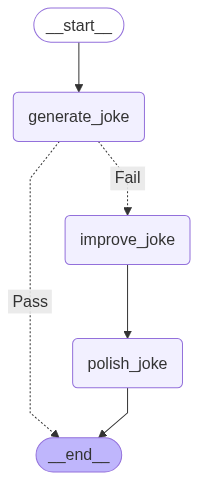

Initial joke:
Why did the cat join a band?

Because it wanted to be the purr-cussionist!

--- --- ---

Joke failed quality gate - no punchline detected!


In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

## Apply this to sentiment and improve the sentiment scoring for `20 hardest sentences`

In [ ]:
!pip install datasets -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.

In [ ]:
from datasets import load_dataset, Dataset, Value

# Load both splits
fpb_50agree = load_dataset("takala/financial_phrasebank", "sentences_50agree", trust_remote_code=True)["train"]

hardest_sentences = [
    "The corresponding share capital increase , EUR 1,012,945.50 was entered in the Trade Register today .",
    "The category was marked by maturity and the recession .",
    "The annual Thesis contest is aimed to enhance the thesis quality and to strengthen the thesis culture in polytechnics .",
    "A state program has been worked out , legal provisions have been developed , and rules and normative documents have been specified for the functioning of a technological park .",
    "This is due to the postponement of the decision-making of projects in the negotiation phase from the earlier estimation .",
    "The order consists of capacity expansion , maintenance services and new charging functionality , the company said .",
    "The bank also expects additional costs , related to the Dash 8 - Q400 jets , which the group shelved in October 2007 .",
    "The construction project is scheduled to start in the second quarter of 2009 and the new building is scheduled to be in place by the end of 2010 .",
    "The Finnish company previously said its operating result will be lower than the break-even posted a year earlier .",
    "Poyry is a global expert in consulting and engineering .",
    "Body The credit falls due February 24 , 2014 .",
    "The implementation of the deal is subject to the approval by the Finnish Competition Authority .",
    "The adjustment measures will be carried out in phases to secure the delivery capability .",
    "The right margin will be viewed separately in detail with every customer .",
    "After that the two companies sat down and sewed up the present deal .",
    "It also has potential clients in the growing environmental and recycling technology sectors .",
    "Public services will also be available .",
    "The world of glass is coming to Egypt and we invite Visitors from all around the world to attend Glass World Exhibition 2009 , Register Now at www.glassworldex.com",
    "The use case dramatically narrows if you go only with the hot s Ltd.",
    "Estimations indicate that even up to 170 different tablet computers or reading devices will be available in 2011 ."
]

# Filter original 50agree for rows with those sentences
filtered_rows = [row for row in fpb_50agree if row['sentence'] in hardest_sentences]

# Create new HuggingFace Dataset
diff_dataset = Dataset.from_list(filtered_rows)
diff_dataset   = diff_dataset.cast_column("label", Value("string"))

print(f"Total unique sentences: {len(diff_dataset)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Total unique sentences: 20


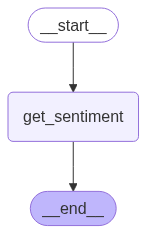

In [ ]:
# Graph state
class State(TypedDict):
    phrase: str
    sentiment: str
    improved_sentiment: str
    final_sentiment: str

# Nodes
def get_sentiment(state: State):


    msg = llm.invoke(f"What is the sentiment of the news headline?\n\n"
                  f"{state['phrase']}\n\n"
                  "OUTPUT ONE OF THREE LABELS: 'Positive'/'Neutral'/'Negative'")
    return {"sentiment": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("get_sentiment", get_sentiment)

workflow.add_edge(START, "get_sentiment")

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:





def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [ ]:


# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

# Parallelization
![parr](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/parallelization.png)


## Basic Example

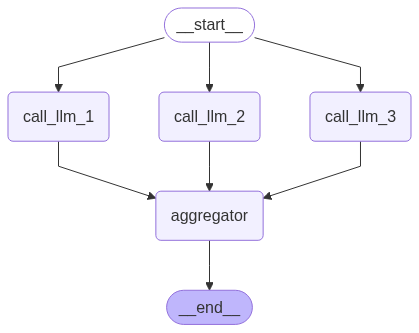

Here's a story, joke, and poem about cats!

STORY:
In a cozy little house on a quiet street, a family of cats lived together in perfect harmony. There was Whiskers, the wise and aged matriarch, who ruled the roost with a gentle paw. Her mate, Fluffy, was a rugged and handsome tom who spent his days lounging in the sunbeams that streamed through the windows.

Their three kittens, Mittens, Patches, and Snowball, were always getting into mischief. They would chase each other around the house, pouncing on invisible prey and sending pillows and blankets flying. Whiskers and Fluffy would watch them with amusement, knowing that they were just going through the natural stages of feline development.

One day, a stray cat named Midnight wandered into the neighborhood. She was a sleek and mysterious cat with piercing green eyes and a mottled black coat. Whiskers immediately sensed that Midnight was different, and she welcomed her into the family with a warm purr and a soft head butt.

Midnight qu

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

## Exercise: Apply self consistency to improve sentiment classification

# Routing
![routing](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/routing.png)

## Basic Example

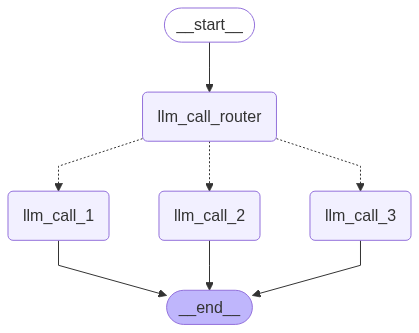

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [ ]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a short joke about cats"})
print(state["output"])

## Exercise: build a router to route harder questions to a larger/reasoning llm

# Orchestrator-Worker
![pic](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/worker.png)

In [ ]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

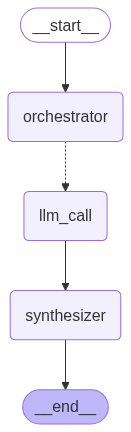

**Introduction and Description: Summary of the Book's Main Theme and Purpose**
============================================================

The book, titled "The Power of Now", delves into the concept of mindfulness and living in the present moment. The author, Eckhart Tolle, explores the idea that people often live in a state of constant distraction and worry about the past or future, missing out on the beauty and simplicity of the present moment. The main theme of the book is the importance of being present and mindful in order to find inner peace and happiness.

The author argues that most people live in a state of unconsciousness, driven by their thoughts and emotions, and that this state is the root of many problems in life, including stress, anxiety, and depression. He proposes that by becoming more aware of the present moment, individuals can break free from this cycle of negativity and find a sense of inner peace and fulfillment.

Throughout the book, Tolle draws upon his own experiences with depression and anxiety, as well as insights from spirituality and philosophy, to illustrate the principles of living in the present moment. He also provides practical advice and exercises for readers to cultivate mindfulness and live more authentically in the present. Overall, the book aims to inspire readers to adopt a more mindful and present approach to life, and to experience the benefits of greater inner peace, happiness, and fulfillment.

---

### Rule 1: Make Sure You Are Standing on Your Own Two Feet
#### Summary and Importance

Standing on your own two feet is the foundation of independence and self-sufficiency. This rule emphasizes the importance of taking ownership of one's actions, decisions, and consequences. It means being responsible for one's life, goals, and choices without relying on others for validation, support, or excuses.

This rule is crucial because it allows individuals to develop a sense of autonomy, self-confidence, and personal accountability. When you stand on your own two feet, you are better equipped to navigate life's challenges, overcome obstacles, and make progress towards your goals. Moreover, it fosters a growth mindset, as you are more likely to take calculated risks, learn from failures, and adapt to changing circumstances.

In practice, this rule means being proactive, self-motivated, and willing to take initiative. It involves setting clear goals, prioritizing tasks, and executing plans without relying on others to do the heavy lifting. By standing on your own two feet, you demonstrate your commitment to personal growth, resilience, and long-term success.

---

### Rule 2: Assume the Responsibility for Your Life


Take control of your life, decisions, and actions. This rule is crucial as it sets the foundation for personal growth and freedom. By assuming responsibility, you acknowledge that you are the captain of your ship and the master of your destiny. This mindset shift empowers you to make conscious choices, take ownership of your mistakes, and develop a sense of accountability.

Consequences of not assuming responsibility include:

* Blaming others for your circumstances
* Feeling helpless and stuck
* Lacking direction and purpose
* Failing to learn from mistakes
* Missing opportunities for growth and improvement

By embracing this rule, you can:

* Develop a sense of autonomy and confidence
* Make informed decisions that align with your values and goals
* Build resilience and adaptability
* Cultivate a growth mindset and learn from failures
* Take calculated risks and seize opportunities

---

### Rule 3: Work Hard, Be Stubborn, and Immerse Yourself in Boring Work

This third rule emphasizes the importance of dedication and perseverance in one's work. It suggests that in order to achieve success, one must be willing to put in the effort required to master their craft, even if it means facing mundane or repetitive tasks. The rule also highlights the importance of stubbornness, implying that one must be willing to stand by their decisions and convictions, even in the face of adversity.

The relevance of this rule lies in its application to various aspects of life. In the workplace, it means being willing to put in the extra hours, attend to the little details, and take on tasks that others may deem too tedious. In personal projects, it means being willing to put in the time and effort required to see them through to completion. In relationships, it means being committed to building and maintaining strong bonds with others.

By following this rule, individuals can develop a strong work ethic, build resilience, and cultivate a sense of pride and accomplishment in their endeavors. It also encourages individuals to be open-minded, flexible, and willing to learn from their mistakes, which is essential for personal and professional growth.

---

**Rule 4: Be Precise in Your Thoughts and Actions**
=====================================================

This rule emphasizes the importance of accuracy and clarity in one's thoughts and actions. It is essential to be precise in all aspects of life, from communication to decision-making, as it helps to avoid misunderstandings, mistakes, and unnecessary conflicts. Precision in thoughts and actions also leads to increased efficiency, productivity, and effectiveness.

Being precise in our thoughts and actions requires discipline, focus, and attention to detail. It involves being mindful of our words, actions, and decisions, and making sure they align with our goals and values. When we are precise, we are able to communicate effectively, build trust with others, and achieve our objectives more easily.

In today's fast-paced and complex world, precision is more important than ever. With the abundance of information and distractions, it is easy to get lost or confused. By being precise in our thoughts and actions, we can stay focused, make better decisions, and achieve our goals more efficiently.

---

### Rule 5: Do Not Let Your Children Do Anything That Makes You Disapproving

This rule emphasizes the importance of setting clear boundaries and expectations for children's behavior. It is essential to establish what behaviors are acceptable and what are not, and to consistently enforce these rules. Parents should not allow their children to engage in behaviors that they disapprove of, as this can lead to confusion, misbehavior, and a lack of respect for authority.

The significance of this rule lies in its ability to promote a sense of structure and stability in the home. When children know what is expected of them, they are more likely to behave appropriately and feel secure in their environment. Additionally, this rule helps parents to maintain their authority and sets a positive example for their children, teaching them the importance of respect and obedience.

By following this rule, parents can create a harmonious and respectful home environment, where children feel supported and guided, and are more likely to develop into responsible and well-adjusted individuals.

---

### Rule 6: Set Your House in Perfect Order Before You Criticize the World

Before we can effectively criticize or change the world, we must first take care of our own personal and internal affairs. This rule emphasizes the importance of self-reflection, self-improvement, and personal responsibility. It encourages us to focus on our own flaws and weaknesses before pointing out those of others.

By setting our own "house" in order, we are able to approach issues with a clearer and more objective mind. We are better equipped to identify and address our own biases, prejudices, and shortcomings, which in turn allows us to approach problems with a sense of humility and accountability.

In essence, this rule is a call to introspection and self-awareness. It reminds us that true change and progress can only be achieved when we first take care of our own personal "mess" and then work towards creating positive change in the world.

---

### Rule 7: Pursue What Is Meaningful (Not What Is Expedient)

To pursue what is meaningful is to prioritize actions that align with one's values and passions, rather than solely focusing on what is expedient or convenient. This rule is crucial in achieving a sense of fulfillment and purpose in life. By focusing on what is meaningful, individuals can create a sense of direction and motivation, which can lead to a more fulfilling and purpose-driven life.

In contrast, pursuing what is expedient can lead to a sense of emptiness and disconnection. When we prioritize convenience over meaning, we may achieve short-term gains, but lose sight of what truly matters in the long run. This approach can also lead to feelings of guilt, regret, and dissatisfaction, as we realize that our actions were driven by self-interest rather than a genuine desire to make a positive impact.

By embracing Rule 7, individuals can cultivate a sense of purpose and direction, and make choices that align with their values and passions. This approach requires intentionality, self-reflection, and a willingness to prioritize what is truly important. By doing so, individuals can live a more authentic, meaningful, and fulfilling life.

---

### Rule 8: Tell the Truth - Or, at Least, Don't Lie

**Summary**
Honesty is the foundation of any meaningful interaction. Rule 8 emphasizes the importance of truth-telling, even if it's uncomfortable or difficult. This principle is crucial in building trust, respect, and credibility with others. By being truthful, individuals demonstrate respect for themselves and others, fostering a stronger sense of community and collaboration.

**Significance**
Lying can lead to the breakdown of relationships, damage to one's reputation, and erosion of trust. When individuals deceive or mislead others, it can create a culture of dishonesty, making it challenging to establish genuine connections. Conversely, a culture of truth-telling promotes transparency, accountability, and open communication, leading to more effective decision-making, improved relationships, and personal growth. By adhering to Rule 8, individuals can maintain their integrity and contribute to a more honest and trustworthy environment.

---

### Rule 9: Assume That the Person You Are Reading About Has Done Something You Would Never Do
In this chapter, we delve into the ninth rule of writing a compelling narrative, which emphasizes the importance of assuming that the person you are reading about has done something you would never do. This rule is crucial in creating a nuanced and engaging story, as it allows the reader to form a connection with the subject matter.

By adopting this perspective, writers can tap into the reader's imagination and curiosity, making the story more relatable and memorable. This approach also enables writers to explore complex themes and emotions, as they are able to consider the subject's motivations and actions from a unique and empathetic standpoint.

Moreover, assuming that the person you are reading about has done something you would never do encourages writers to challenge their own biases and preconceptions. By putting themselves in the shoes of others, writers can gain a deeper understanding of human nature, fostering a more compassionate and open-minded approach to storytelling.

In conclusion, Rule 9 serves as a powerful reminder of the importance of empathy and understanding in the writing process. By assuming that the person you are reading about has done something you would never do, writers can craft stories that resonate with readers, challenge their perspectives, and ultimately leave a lasting impact.

---

### Rule 10: Be Precise in Your Words

It is essential to be precise in your words when writing or speaking. This rule is crucial because it helps to avoid confusion, misunderstandings, and miscommunication. Precise language ensures that your message is conveyed clearly and accurately, reducing the risk of misinterpretation.

---

**Rule 11: Do Not Let Your Children Do Anything That Makes You Disapproving**
============================================================

This rule emphasizes the importance of setting clear boundaries and expectations for children's behavior. By not allowing them to engage in activities that displease or disapprove of, parents can maintain a sense of control and authority in the relationship. This rule also encourages parents to communicate their values and standards to their children, helping them develop a sense of right and wrong.

The significance of this rule lies in its ability to promote a positive and respectful parent-child dynamic. When children are aware of their parents' expectations and boundaries, they are more likely to feel secure and supported, which can lead to increased confidence and self-esteem. Additionally, this rule helps parents model healthy communication and conflict resolution skills for their children, teaching them how to navigate disagreements and disagreements in a constructive manner.

By following this rule, parents can establish a strong foundation for their relationship with their children, built on trust, respect, and open communication. This, in turn, can have a positive impact on the child's emotional and social development, as well as their ability to navigate complex social situations and relationships in the future.

---

**Rule 12: Choose Your Battles Wisely**
=====================================

The twelfth rule, "Choose Your Battles Wisely", emphasizes the importance of being strategic in one's efforts and resources. It highlights the need to prioritize and focus on the most critical issues, rather than spreading oneself too thin and getting bogged down in trivial or unnecessary conflicts.

This rule is particularly relevant in today's fast-paced and complex world, where the stakes are high and the pressure to perform is immense. It is essential to be selective and intentional in one's battles, as investing time, energy, and resources in the wrong areas can lead to burnout, frustration, and ultimately, failure.

By choosing your battles wisely, you can conserve your energy, maintain your focus, and increase your chances of success. This rule is not about avoiding challenges or conflicts altogether, but rather about being smart and strategic in your approach, and targeting the most critical and impactful areas where you can make a meaningful difference.

In [ ]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on the 12 rules of life summary"})

from IPython.display import Markdown
Markdown(state["final_report"])

# Evaluator-optimizer
![pic](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/evaluator_optimizer.png)

## Basic Example

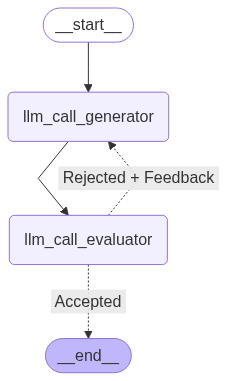

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

## Exercise: Get a reviewer to review the sentiment before confirming

# Agent
![pic](https://langchain-ai.github.io/langgraph/tutorials/workflows/img/agent.png)

In [ ]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)


# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'dpc5kbv2j',
  'type': 'tool_call'}]

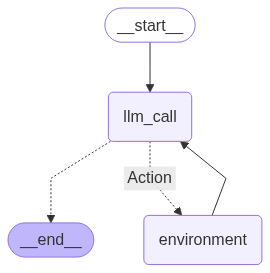

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (r7y6cj0ax)
 Call ID: r7y6cj0ax
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  add (p5rvzf1et)
 Call ID: p5rvzf1et
  Args:
    a: 7
    b: 5
================================= Tool Message =================================

12
================================== Ai Message ==================================
Tool Calls:
  add (stzc9r3ca)
 Call ID: stzc9r3ca
  Args:
    a: 12
    b: 9
================================= Tool Message =================================

21
================================== Ai Message ==================================

The answer is 21.


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

# Exercise: Implement a basic deep search agent

In [ ]:
%pip install -qU langchain_community langchain_fireworks duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.2/569.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 96.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [ ]:
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field, field_validator

In [ ]:
import json
from typing import TypedDict
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END

# State definition
class SearchState(TypedDict):
    question: str
    search_query: str
    search_results: str
    answer: str
    reasoning: str
    is_good_enough: bool
    iteration_count: int

# Initialize tools and LLM
web_search_tool = DuckDuckGoSearchAPIWrapper(max_results=3)
# web_search_tool = TavilySearchResults(k=3)
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

def generate_search_query(state):
    """Generate or refine search query based on the question"""
    question = state["question"]
    iteration = state.get("iteration_count", 0)

    if iteration == 0:
        # First iteration - use original question
        search_query = question
    else:
        # Refine query based on previous results
        system_prompt = """You are a search query optimizer. Given a question and previous search results that weren't satisfactory,
        generate a better, more specific search query that might yield better results."""

        human_prompt = f"""
        Original question: {question}
        Previous search query: {state.get('search_query', '')}
        Previous results were not satisfactory. Generate a better search query.
        """

        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=human_prompt)
        ]

        response = llm.invoke(messages)
        search_query = response.content.strip()

    return {
        **state,
        "search_query": search_query,
        "iteration_count": iteration + 1
    }

def web_search(state):
    """Perform web search using DuckDuckGo"""
    search_query = state["search_query"]

    # Perform search
    search_results = web_search_tool._ddgs_text(search_query)

    # Format results
    formatted_results = "\n\n".join([
        f"Title: {result['title']}\nContent: {result['body']}"
        for result in search_results
    ])

    return {
        **state,
        "search_results": formatted_results
    }

def generate_answer_and_reasoning(state):
    """Generate answer and reasoning from search results"""
    question = state["question"]
    search_results = state["search_results"]

    system_prompt = """You are a helpful assistant that provides comprehensive answers based on search results.
    Provide both an answer and your reasoning for why this answer addresses the question well."""

    human_prompt = f"""
    Question: {question}

    Search Results:
    {search_results}

    Based on these search results, provide:
    1. A comprehensive answer to the question
    2. Your reasoning for why this answer is good and addresses the question

    Format your response as JSON with 'answer' and 'reasoning' fields.
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt)
    ]

    response = llm.invoke(messages)

    try:
        parsed_response = json.loads(response.content)
        answer = parsed_response.get("answer", "")
        reasoning = parsed_response.get("reasoning", "")
    except:
        # Fallback if JSON parsing fails
        answer = response.content
        reasoning = "Generated from search results"

    return {
        **state,
        "answer": answer,
        "reasoning": reasoning
    }

def evaluate_answer_quality(state):
    """Evaluate if the answer is good enough"""
    question = state["question"]
    answer = state["answer"]
    reasoning = state["reasoning"]
    iteration_count = state["iteration_count"]

    # Stop after 3 iterations to prevent infinite loops
    if iteration_count >= 3:
        return {**state, "is_good_enough": True}

    system_prompt = """You are an answer quality evaluator. Determine if the provided answer adequately addresses the question.
    Consider completeness, accuracy, and relevance."""

    human_prompt = f"""
    Question: {question}
    Answer: {answer}
    Reasoning: {reasoning}

    Is this answer good enough to satisfy the question? Respond with only 'yes' or 'no'.
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt)
    ]

    response = llm.invoke(messages)
    is_good = response.content.strip().lower() == "yes"

    return {
        **state,
        "is_good_enough": is_good
    }

def should_continue(state):
    """Decide whether to continue searching or end"""
    return "continue" if not state["is_good_enough"] else "end"

# Build the graph
workflow = StateGraph(SearchState)

# Add nodes
workflow.add_node("generate_query", generate_search_query)
workflow.add_node("search", web_search)
workflow.add_node("generate_answer", generate_answer_and_reasoning)
workflow.add_node("evaluate", evaluate_answer_quality)

# Add edges
workflow.add_edge(START, "generate_query")
workflow.add_edge("generate_query", "search")
workflow.add_edge("search", "generate_answer")
workflow.add_edge("generate_answer", "evaluate")

# Conditional edge for looping
workflow.add_conditional_edges(
    "evaluate",
    should_continue,
    {
        "continue": "generate_query",
        "end": END
    }
)

# Compile the graph
app = workflow.compile()

# Usage example
def search_and_answer(question: str):
    """Main function to search and answer a question"""
    initial_state = {
        "question": question,
        "search_query": "",
        "search_results": "",
        "answer": "",
        "reasoning": "",
        "is_good_enough": False,
        "iteration_count": 0
    }

    final_state = app.invoke(initial_state)

    return {
        "question": final_state["question"],
        "final_answer": final_state["answer"],
        "reasoning": final_state["reasoning"],
        "iterations": final_state["iteration_count"],
        "search_queries_used": final_state["search_query"]
    }

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = search_and_answer("What does sam altman mean by gentle singularity?")

In [ ]:
print(f"Question: {result['question']}")
print(f"Answer: {result['final_answer']}")
print(f"Reasoning: {result['reasoning']}")
print(f"Iterations: {result['iterations']}")

Question: What does sam altman mean by gentle singularity?
Answer: ```json
{
  "answer": "Sam Altman's concept of a 'Gentle Singularity' refers to a future where artificial general intelligence (AGI) is developed in a way that aligns with human values and promotes a beneficial outcome for society. According to Altman, we have already entered a phase of technological takeoff, and the goal is to ensure that AI systems learn and act in ways that align with what humanity collectively wants in the long term. In this vision of the future, knowledge becomes increasingly accessible and coordination among humans and AI systems becomes seamless. The gentle singularity implies a future where the development of AGI is managed in a way that avoids the pitfalls often associated with advanced AI, such as misaligned goals (as seen in social media algorithms that prioritize engagement over well-being).",
  
  "reasoning": "This answer addresses the question well because it directly incorporates informa

# Exercise: Agentic Rag

In [ ]:
# %%capture --no-stderr
%pip install -qU langchain-community langchain-text-splitters chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00


In [ ]:
import os
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
# Initialize models
llm = ChatGroq(model="llama3-8b-8192", temperature=0)
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Create vector store and retriever
def setup_vectorstore():
    # Load and process documents
    urls = [
        "https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    ]

    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500, chunk_overlap=50
    )
    doc_splits = text_splitter.split_documents(docs_list)

    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        embedding=embeddings,
        collection_name="rag-chroma"
    )
    return vectorstore.as_retriever()

retriever = setup_vectorstore()

# Create retriever tool
@tool
def retrieve_documents(query: str) -> str:
    """Retrieve relevant documents and definitions for the given query about AI agents, hallucination, and related topics."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

# Document grading schema
class GradeDocuments(BaseModel):
    """Grade documents for relevance."""
    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, 'no' if not relevant"
    )

# Graph nodes
def generate_query_or_respond(state: MessagesState):
    """Generate response or decide to retrieve documents."""
    response = llm.bind_tools([retrieve_documents]).invoke(state["messages"])
    return {"messages": [response]}

def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    """Grade retrieved documents for relevance."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    grade_prompt = f"""
    You are a grader assessing relevance of retrieved documents to a user question.

    Retrieved document: {context}
    User question: {question}

    If the document contains information related to the question, grade it as relevant.
    Give a binary score 'yes' or 'no'.
    """

    grader = llm.with_structured_output(GradeDocuments)
    result = grader.invoke([HumanMessage(content=grade_prompt)])

    return "generate_answer" if result.binary_score == "yes" else "rewrite_question"

def generate_answer(state: MessagesState):
    """Generate final answer using retrieved context."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    # Print the retrieved context
    print("---RETRIEVED CONTEXT---")
    print(context)
    print("---END CONTEXT---")


    answer_prompt = f"""
    You are an assistant for question-answering tasks.
    Use the following context to answer the question.
    If you don't know the answer, say so.
    Keep the answer concise (3 sentences max).

    Question: {question}
    Context: {context}
    """

    response = llm.invoke([HumanMessage(content=answer_prompt)])
    return {"messages": [response]}

def rewrite_question(state: MessagesState):
    """Rewrite question for better retrieval."""

    print("---REWRITING QUESTION---")  # Add this line
    question = state["messages"][0].content

    rewrite_prompt = f"""
    You are a question re-writer. Re-write the following question to be more specific
    and likely to retrieve relevant documents from a vector database.

    Original question: {question}

    Provide only the rewritten question.
    """

    response = llm.invoke([HumanMessage(content=rewrite_prompt)])
    return {"messages": [HumanMessage(content=response.content)]}

# Build the graph
workflow = StateGraph(MessagesState)
# Add nodes
workflow.add_node("generate_query_or_respond", generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retrieve_documents]))
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("rewrite_question", rewrite_question)

# Add edges
workflow.add_edge(START, "generate_query_or_respond")

# Conditional routing based on tool calls
workflow.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

# Grade documents and route accordingly
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate_answer": "generate_answer",
        "rewrite_question": "rewrite_question",
    },
)

workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile the graph
app = workflow.compile()

In [ ]:
def run_agentic_rag(question: str):
    config = {"configurable": {"thread_id": "1"}}
    final_state = None

    for chunk in app.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config,
        stream_mode="values"  # Stream full state values
    ):
        print(f"Current state: {list(chunk.keys())}")
        final_state = chunk

    if final_state and "messages" in final_state:
        return final_state["messages"][-1].content
    return "No answer generated"

In [ ]:
question = "What are the key components of an AI agent?"
answer = run_agentic_rag(question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Current state: ['messages']
Current state: ['messages']
Current state: ['messages']
---RETRIEVED CONTEXT---
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#

Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#

Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#

Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
---END CONTEXT---
Current state: ['messages']
Question: What are the key components of an AI agent?
Answer: Based on the provided context, the key components of an AI agent mentioned are:

* Planning: This involves breaking down a complex task into smaller steps and planning ahead.
* Task Decomposition: 

In [ ]:
question = "why does an agent hallucinate?"
answer = run_agentic_rag(question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Current state: ['messages']
Current state: ['messages']
Current state: ['messages']
---RETRIEVED CONTEXT---
Planning is essentially in order to optimize believability at the moment vs in time.
Prompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)
Relationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.
Environment information is present in a tree structure.





The generative agent architecture. (Image source: Park et al. 2023)

Planning is essentially in order to optimize believability at the moment vs in time.
Prompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)
Relationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.
Environment information is present in a tree structure.





The generative agent architecture. (Image source: Park et al. 2023)

Planning is essentially in order t

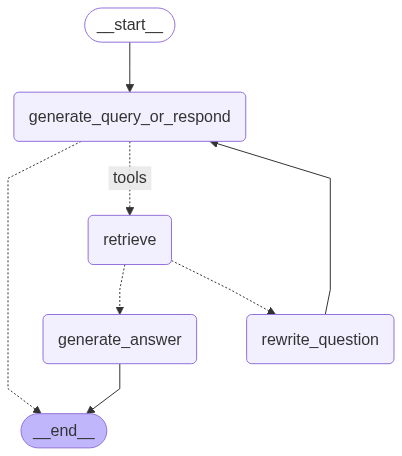

In [ ]:
# Show workflow
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# question = "Compare and contrast the role of 'memory' in autonomous agents with the principles of prompt engineering discussed in the blog posts. How might the integration of prompt engineering techniques address limitations in an agent's memory system, and what novel challenges could arise from such integration?"
# question = """Analyze the interplay between query rewriting and document grading in the RAG pipeline. Specifically:

# 1. How might iterative query rewriting improve the precision of retrieved documents for ambiguous or multi-faceted questions?
# 2. What thresholds or criteria could the 'grade_documents' step use to determine if retrieved content is sufficient for generating a reliable answer?
# 3. Design a hypothetical scenario where the system fails to answer correctly without query rewriting, but succeeds when the rewrite step is activated. Use examples from the blog posts to ground your analysis."""
question = """- Locate every place where the author explicitly describes or exemplifies a failure mode of LLM-based agents (e.g., hallucination, tool-use brittleness, prompt drift, evaluation blind spots, error propagation). Quote each passage verbatim (≤ 40 words) and give its section heading.

- For each failure mode, identify one concrete prompt-engineering tactic from the March post that could mitigate it, and explain the link in one sentence.

- Add a quantitative metric you would log in a production agent to detect this failure early.

- Present the information in a four-column table: Failure Mode | Quote & Section | Mitigating Tactic | Monitoring Metric.

- From the completed table, distil three overarching design principles for building robust, self-correcting agents, and justify each with evidence from multiple rows in the table."""
answer = run_agentic_rag(question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Node: generate_query_or_respond
---
Question: - Locate every place where the author explicitly describes or exemplifies a failure mode of LLM-based agents (e.g., hallucination, tool-use brittleness, prompt drift, evaluation blind spots, error propagation). Quote each passage verbatim (≤ 40 words) and give its section heading.

- For each failure mode, identify one concrete prompt-engineering tactic from the March post that could mitigate it, and explain the link in one sentence.

- Add a quantitative metric you would log in a production agent to detect this failure early.

- Present the information in a four-column table: Failure Mode | Quote & Section | Mitigating Tactic | Monitoring Metric.

- From the completed table, distil three overarching design principles for building robust, self-correcting agents, and justify each with evidence from multiple rows in the table.
Answer: None
